In [1]:
import os
os.chdir('/grid_mnt/data_cms_upgrade/biriukov/TICL_Validation/python')
from validation.DataFile import *
from typing import List, Union
import re

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
#plt.rcParams['text.usetex'] = True
import mplhep as hep
plt.style.use(hep.style.CMS)
e_5_30_pu0 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_5_30/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'
e_5_30_pu200 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_5_30/step3/14_2_0_pre1/dumper/dumper_merged_1_30.root'
e_10_1000_pu0 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_10_1000/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'
e_10_1000_pu200 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_10_1000/step3/14_2_0_pre1/dumper/dumper_merged_1_60.root'

filepath = {
    'e_5_30_pu0': e_5_30_pu0,
    'e_5_30_pu200': e_5_30_pu200,
    'e_10_1000_pu0': e_10_1000_pu0,
    'e_10_1000_pu200': e_10_1000_pu200
}

tfile = DataFile(filepath['e_10_1000_pu0'])

In [99]:
def broadcastArrays(target_array,
                    reference_array):
    
    lengths_ref = ak.num(reference_array)
    tar_flat = ak.flatten(target_array)

    tar_broadcasted_flat = ak.broadcast_arrays(tar_flat, reference_array)[0]
    tar_broadcasted = ak.unflatten(ak.flatten(tar_broadcasted_flat), lengths_ref)

    return tar_broadcasted

def flatten(array):
    return np.array(ak.flatten(array))

def removeNaN(array, nan_map):
    pass

def processData(data_key: str,
                binning_keys: List[str],
                nbins: List[str],
                binning_opt: List[str],
                pca_match: str,
                dependencies: List[str],
                gen_match: bool = False):
    
    if len(binning_keys) != len(nbins):
        raise ValueError(f'Number of binning keys must be equal to length of nbins (current: {len(binning_keys)}, {len(nbins)})')
    
    if len(binning_keys) != len(binning_opt):
        raise ValueError(f'Number of binning keys must be equal to number of binning options')
    
    var_dict = {
        'eta': r'$\eta$',
        'phi': r'$\phi$',
        'e_raw': r'$E_\text{reco}^\text{raw}$',
        'e_reg': r'$E_\text{reco}^\text{regressed}$',
        'e_seed': r'$E_\text{seed}$',
        'pT': r'p_T'
    }

    binning_path = {
        'eta': ('ticlDumper/trackstersCLUE3DHigh', 'barycenter_eta'),
        'phi': ('ticlDumper/trackstersCLUE3DHigh', 'barycenter_phi'), 
        'e_raw': ('ticlDumper/trackstersCLUE3DHigh', 'raw_energy'),
        'e_reg': ('ticlDumper/trackstersCLUE3DHigh', 'regressed_energy'),
        'e_seed': ('ticlDumper/simtrackstersCP', 'raw_energy'),
        'pT': ('ticlDumper/trackstersCLUE3DHigh', 'raw_pt')
    }

    dependencies_dict = {
        'ev': ('ticlDumper/trackstersCLUE3DHigh', ['EV1', 'EV2', 'EV3']),
        'trackster_raw_energy': ('ticlDumper/trackstersCLUE3DHigh', 'raw_energy'),
        'trackster_regressed_energy': ('ticlDumper/trackstersCLUE3DHigh', 'regressed_energy'),
        'seed_energy': ('ticlDumper/simtrackstersCP', 'raw_energy'),
        'cp_energy': ('ticlDumper/simtrackstersCP', 'regressed_energy')
    }

    # Extract data
    reco_eVector = []
    for axis in 'x', 'y', 'z':
        reco_eVector.append(tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key=f"eVector0_{axis}"))

    sim_eVector = []
    if pca_match == 'pca':
        for axis in 'x', 'y', 'z':
            sim_eVector.append(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key=f"eVector0_{axis}"))
    if pca_match == 'boundary':
        for axis in 'X', 'Y', 'Z':
            sim_eVector.append(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key=f"boundary{axis}"))
    
    dependency_arrays = []
    for dependency in dependencies:
        dep_branch_key = dependencies_dict[dependency]
        if type(dep_branch_key[1]) == list:
            dep_vec = []
            for key in dep_branch_key[1]:
                dep_vec.append(tfile.openArray(dep_branch_key[0], key))
            dependency_arrays.append(dep_vec)
        else:
            dependency_arrays.append(tfile.openArray(dep_branch_key[0], dep_branch_key[1]))

    # Compute theta reco and sim
    dxy_reco = np.sqrt(reco_eVector[0]*reco_eVector[0] + reco_eVector[1]*reco_eVector[1])
    theta_reco = np.atan(dxy_reco/reco_eVector[2])

    dxy_sim = np.sqrt(sim_eVector[0]*sim_eVector[0] + sim_eVector[1]*sim_eVector[1])
    theta_sim = np.atan(dxy_sim/sim_eVector[2])

    # Broadcast simtrackstersCP arrays' shape to trackstersCLUE3DHigh ones'

    theta_sim = broadcastArrays(theta_sim, theta_reco)
    for key, i in zip(dependencies, range(len(dependency_arrays))):
        if dependencies_dict[key][0].split('/')[1] == 'simtrackstersCP':                # broadcast only arrays from simtrackstersCP branch
            if type(dependency_arrays[i]) == list:
                new_array = []
                for ar in dependency_arrays[i]:
                    ar = broadcastArrays(ar, theta_reco)
                    new_array.append(ar)
                dependency_arrays[i] = new_array
            else:
                dependency_arrays[i] = broadcastArrays(dependency_arrays[i], theta_reco)

    # Extract binning data
    binning_arrays = []
    for key in binning_keys:
        bin_key = binning_path[key]
        binning_data = tfile.openArray(bin_key[0], bin_key[1])
        if gen_match:
            binning_data = binning_data[recoToSim_score < 0.2]
        binning_arrays.append(binning_data)

    # Broadcast binning arrays
    for key, i in zip(binning_keys, range(len(binning_arrays))):
        if binning_path[key][0].split('/')[1] == 'simtrackstersCP':
            binning_arrays[i] = broadcastArrays(binning_arrays[i], theta_reco)
    
    # Remove nan values (change all nan values to 9999 and then mask them)
    # First, create a nan map
    nan_map = np.isnan(theta_sim) | np.isnan(theta_reco)
    for dependency_array in dependency_arrays:
        if type(dependency_array) == list:
            for array in dependency_array:
                nan_map = nan_map | np.isnan(array)
        else:
            nan_map = nan_map | np.isnan(dependency_array)

    for binning_array in binning_arrays:
        nan_map = nan_map | np.isnan(binning_array)
    
    # Second, substitute values at least in one array equal to nan to nan_to_val (by default 9999)
    # Third, mask these values
    nan_to_val = 9999

    theta_sim = ak.where(nan_map, nan_to_val, theta_sim)
    theta_sim = theta_sim[theta_sim != nan_to_val]

    theta_reco = ak.where(nan_map, nan_to_val, theta_reco)
    theta_reco = theta_reco[theta_reco != nan_to_val]

    for i in range(len(dependency_arrays)):
        if type(dependency_arrays[i]) == list:
            new_array = []
            for array in dependency_arrays[i]:
                array = ak.where(nan_map, nan_to_val, array)
                new_array.append(array[array != nan_to_val])
            dependency_arrays[i] = new_array
        else:
            array = ak.where(nan_map, nan_to_val, dependency_arrays[i])
            dependency_arrays[i] = array[array != nan_to_val]
    
    for i in range(len(binning_arrays)):
        array = ak.where(nan_map, nan_to_val, binning_arrays[i])
        binning_arrays[i] = array[array != nan_to_val]

    return theta_reco, theta_sim, dependency_arrays, binning_arrays

In [100]:
test_data = processData(data_key = None,
            binning_keys = ['eta' ,'e_seed'],
            nbins = [10, 10],
            binning_opt = ['lin', 'lin'],
            pca_match = 'pca',
            dependencies = ['ev', 'trackster_regressed_energy', 'seed_energy'],
            gen_match = None)

/grid_mnt/data__data.polcms/cms/biriukov/software/miniforge3/envs/jlabenv/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:249: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [102]:
test_data[1]

<Array [[0.359], ..., [0.156, 0.156, ..., 0.156]] type='100000 * var * float64'>

In [43]:
test_data[2]

{'ev': [<Array [[33.8], ..., [28, 45.1, ..., 49.8, 29.4]] type='100000 * var * float32'>,
  <Array [[0.136], ..., [4.55, 0.00317, ..., 3.34]] type='100000 * var * float32'>,
  <Array [[0.0228], ..., [0.668, ..., 0.865]] type='100000 * var * float32'>],
 'trackster_regressed_energy': <Array [[21.2], ..., [12.5, 800, ..., 9.36]] type='100000 * var * float32'>,
 'seed_energy': <Array [[21.4], [64.7], [147], ..., [785], [820]] type='100000 * var * float32'>}

In [2]:
data = []
for axis in 'x', 'y', 'z':
    data.append(tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key=f"eVector0_{axis}"))

orig_dir = []
for axis in 'X', 'Y', 'Z':
    orig_dir.append(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key=f"boundary{axis}"))

ev = []
for num in 1,2,3:
    ev.append(tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key=f"EV{num}"))

# ratio EV_1/(EV_1 + EV_2 + EV_3). Check trackster's shape
ev_1_ratio = ev[0]/(ev[0] + ev[1] + ev[2])

dxy = np.sqrt(data[0]*data[0] + data[1]*data[1])
theta = np.atan(dxy/data[2])

dxy_orig = np.sqrt(orig_dir[0]*orig_dir[0] + orig_dir[1]*orig_dir[1])
theta_dir = np.atan(dxy_orig/orig_dir[2])

lengths = ak.num(theta)
theta_dir_flat = ak.flatten(theta_dir)

theta_dir_broadcasted = ak.broadcast_arrays(theta_dir_flat, theta)[0]
theta_dir_result = ak.unflatten(ak.flatten(theta_dir_broadcasted), lengths)

dth = np.abs(theta - theta_dir_result)
dth_flat = ak.flatten(dth)
del_theta_flat = ak.drop_none(ak.mask(dth_flat, ~np.isnan(dth_flat)))
del_theta_flat = del_theta_flat

trackster_energy = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="raw_energy")
trackster_energy = ak.where(np.isnan(dth), -1, trackster_energy)
trackster_energy = trackster_energy[trackster_energy > 0.]

ev_1_ratio = ak.where(np.isnan(dth), -1, ev_1_ratio)
ev_1_ratio = ak.flatten(ev_1_ratio[ev_1_ratio > 0])

/grid_mnt/data__data.polcms/cms/biriukov/software/miniforge3/envs/jlabenv/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:249: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [5]:
tfile.getBranchKeys('ticlDumper/simtrackstersCP')

['event',
 'event/run_',
 'event/luminosityBlock_',
 'event/event_',
 'NTracksters',
 'NClusters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'barycenter_eta',
 'barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'regressed_pt',
 'pdgID',
 'trackIdx',
 'trackTime',
 'timeBoundary',
 'boundaryX',
 'boundaryY',
 'boundaryZ',
 'boundaryEta',
 'boundaryPhi',
 'boundaryPx',
 'boundaryPy',
 'boundaryPz',
 'track_boundaryX',
 'track_boundaryY',
 'track_boundaryZ',
 'track_boundaryEta',
 'track_boundaryPhi',
 'track_boundaryPx',
 'track_boundaryPy',
 'track_boundaryPz',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_time',
 'vertices_timeErr',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity']

(array([1.9049e+05, 6.7164e+04, 3.9102e+04, 2.2127e+04, 1.2223e+04,
        6.6830e+03, 3.8340e+03, 2.2270e+03, 1.3750e+03, 8.3900e+02,
        4.9500e+02, 3.4800e+02, 2.6800e+02, 1.8700e+02, 1.4400e+02,
        9.2000e+01, 6.4000e+01, 4.8000e+01, 3.9000e+01, 2.1000e+01]),
 array([1.63912773e-07, 6.99353218e-02, 1.39870480e-01, 2.09805638e-01,
        2.79740810e-01, 3.49675953e-01, 4.19611096e-01, 4.89546299e-01,
        5.59481442e-01, 6.29416585e-01, 6.99351728e-01, 7.69286931e-01,
        8.39222074e-01, 9.09157217e-01, 9.79092419e-01, 1.04902744e+00,
        1.11896265e+00, 1.18889785e+00, 1.25883293e+00, 1.32876813e+00,
        1.39870334e+00]),
 <BarContainer object of 20 artists>)

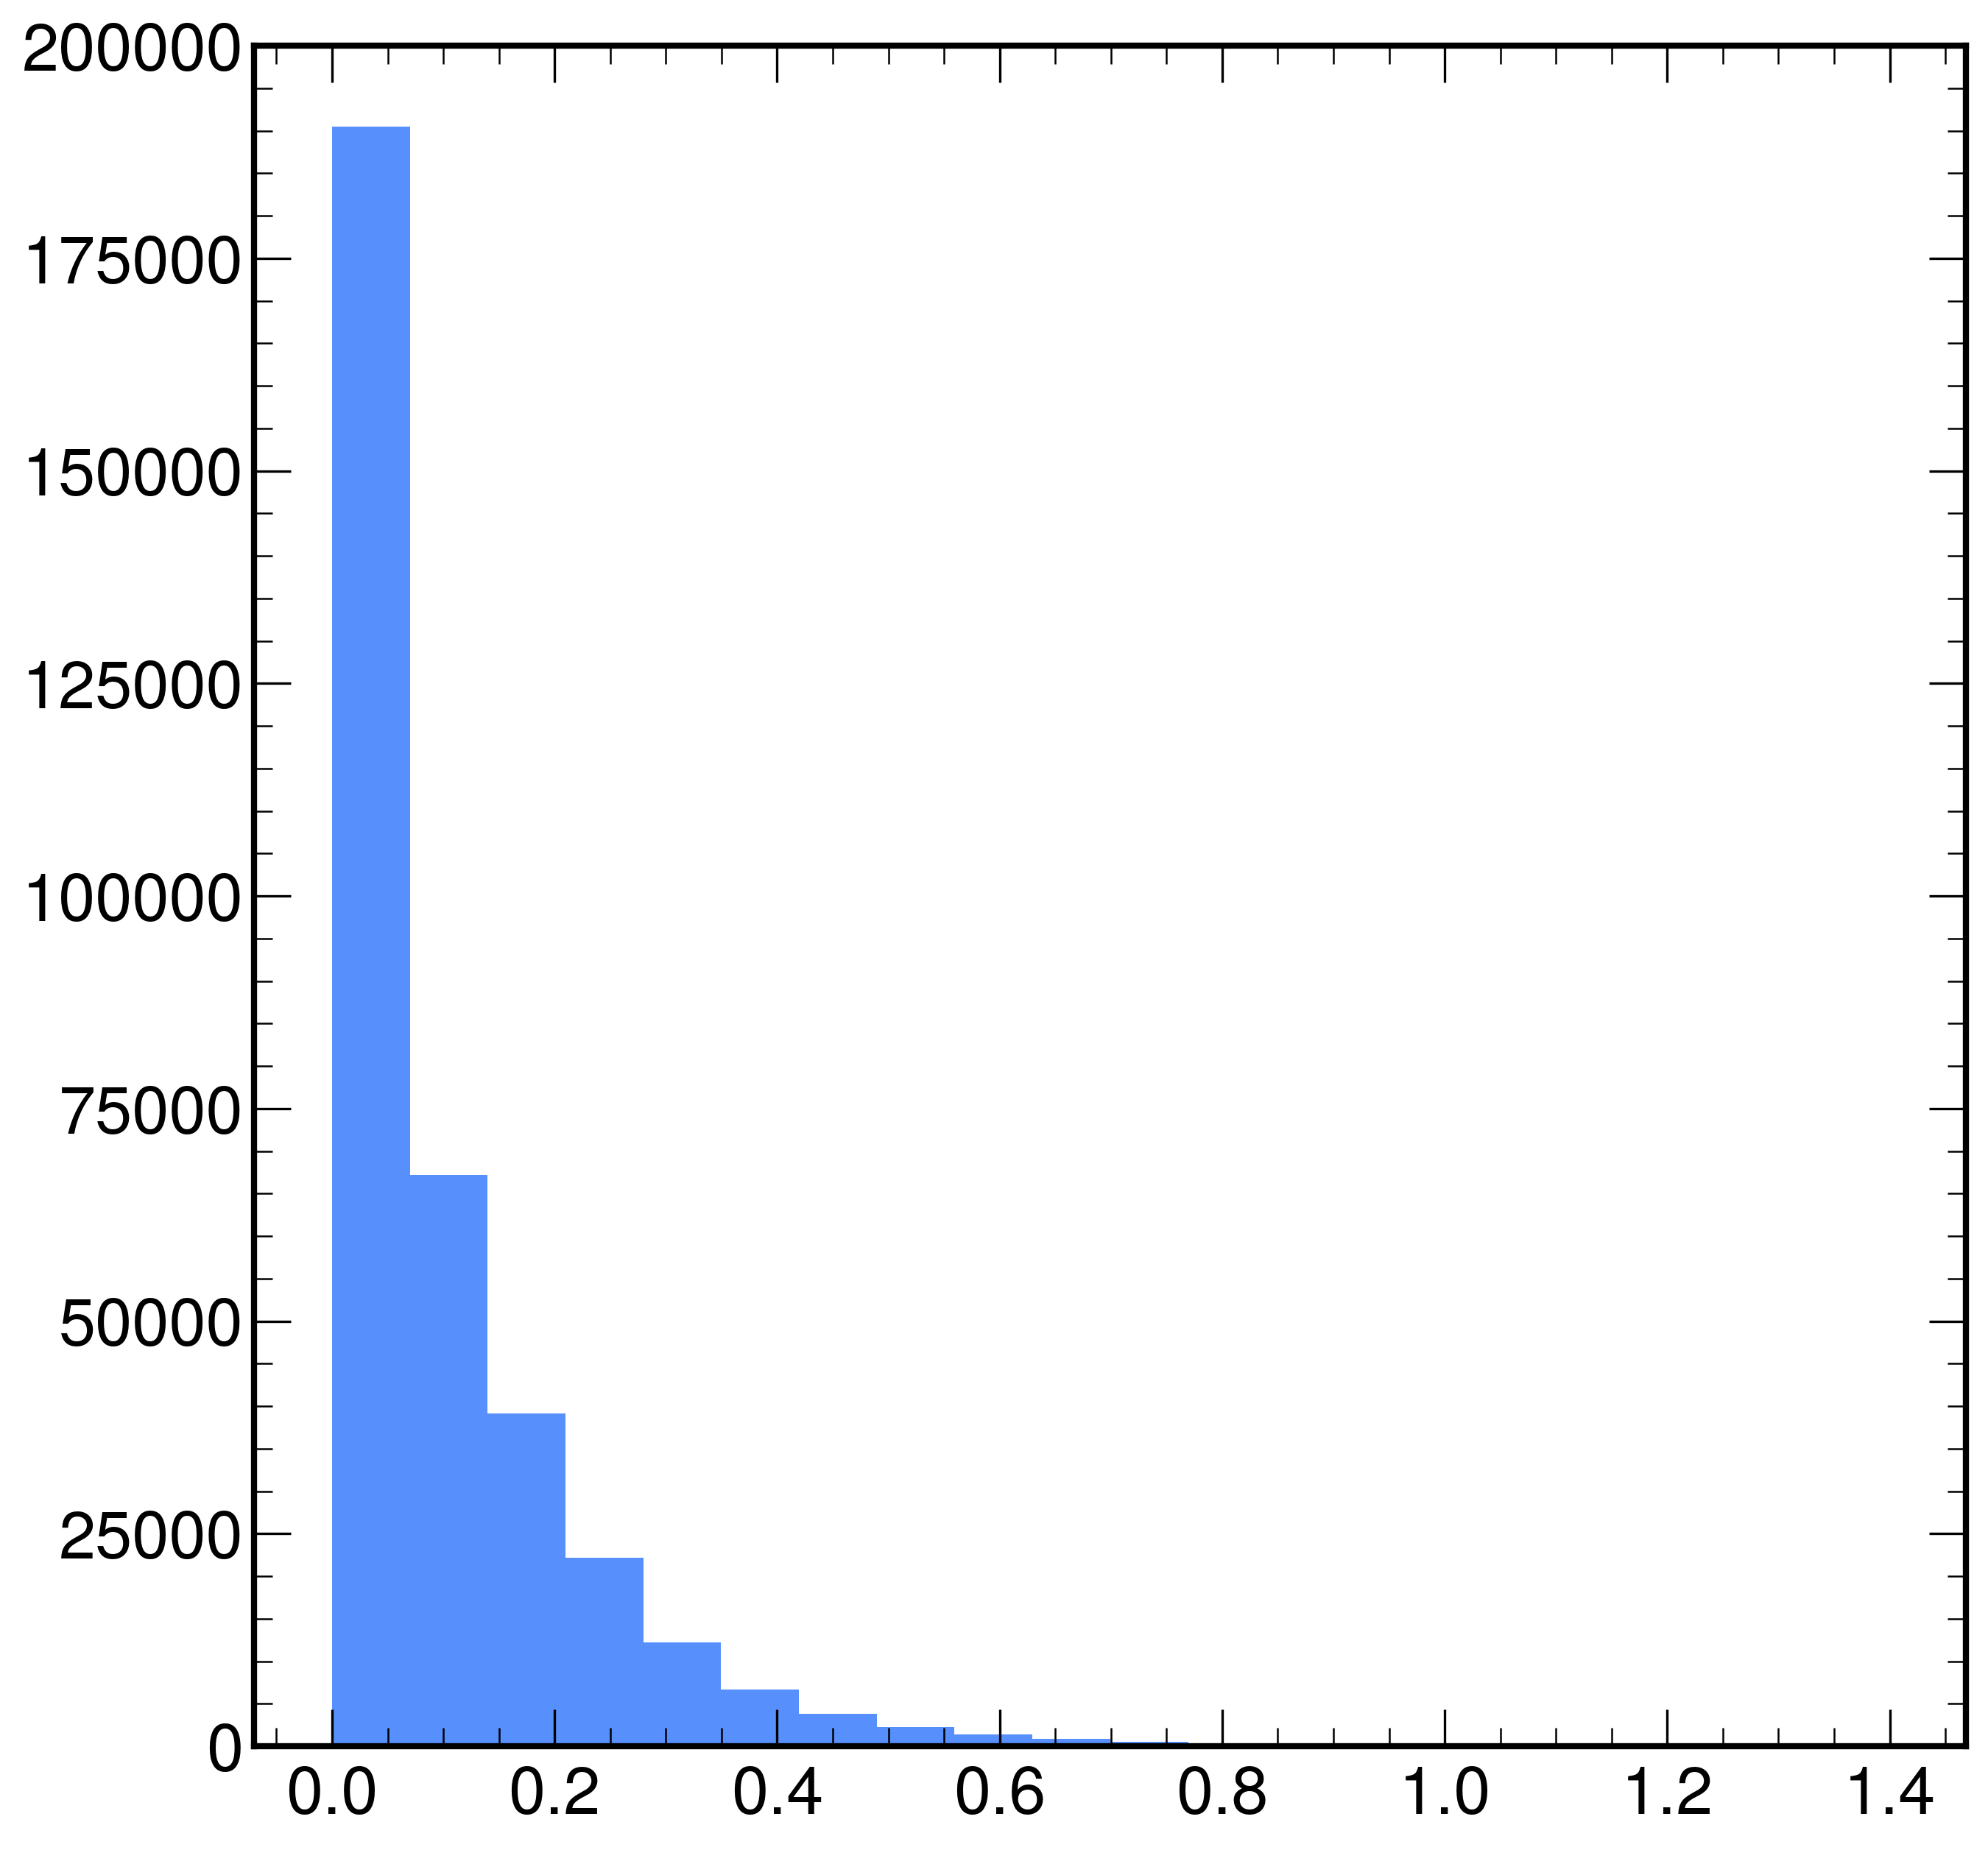

In [4]:
fig, ax = plt.subplots()
ax.hist(del_theta_flat, 20)
#ax.set_yscale('log')

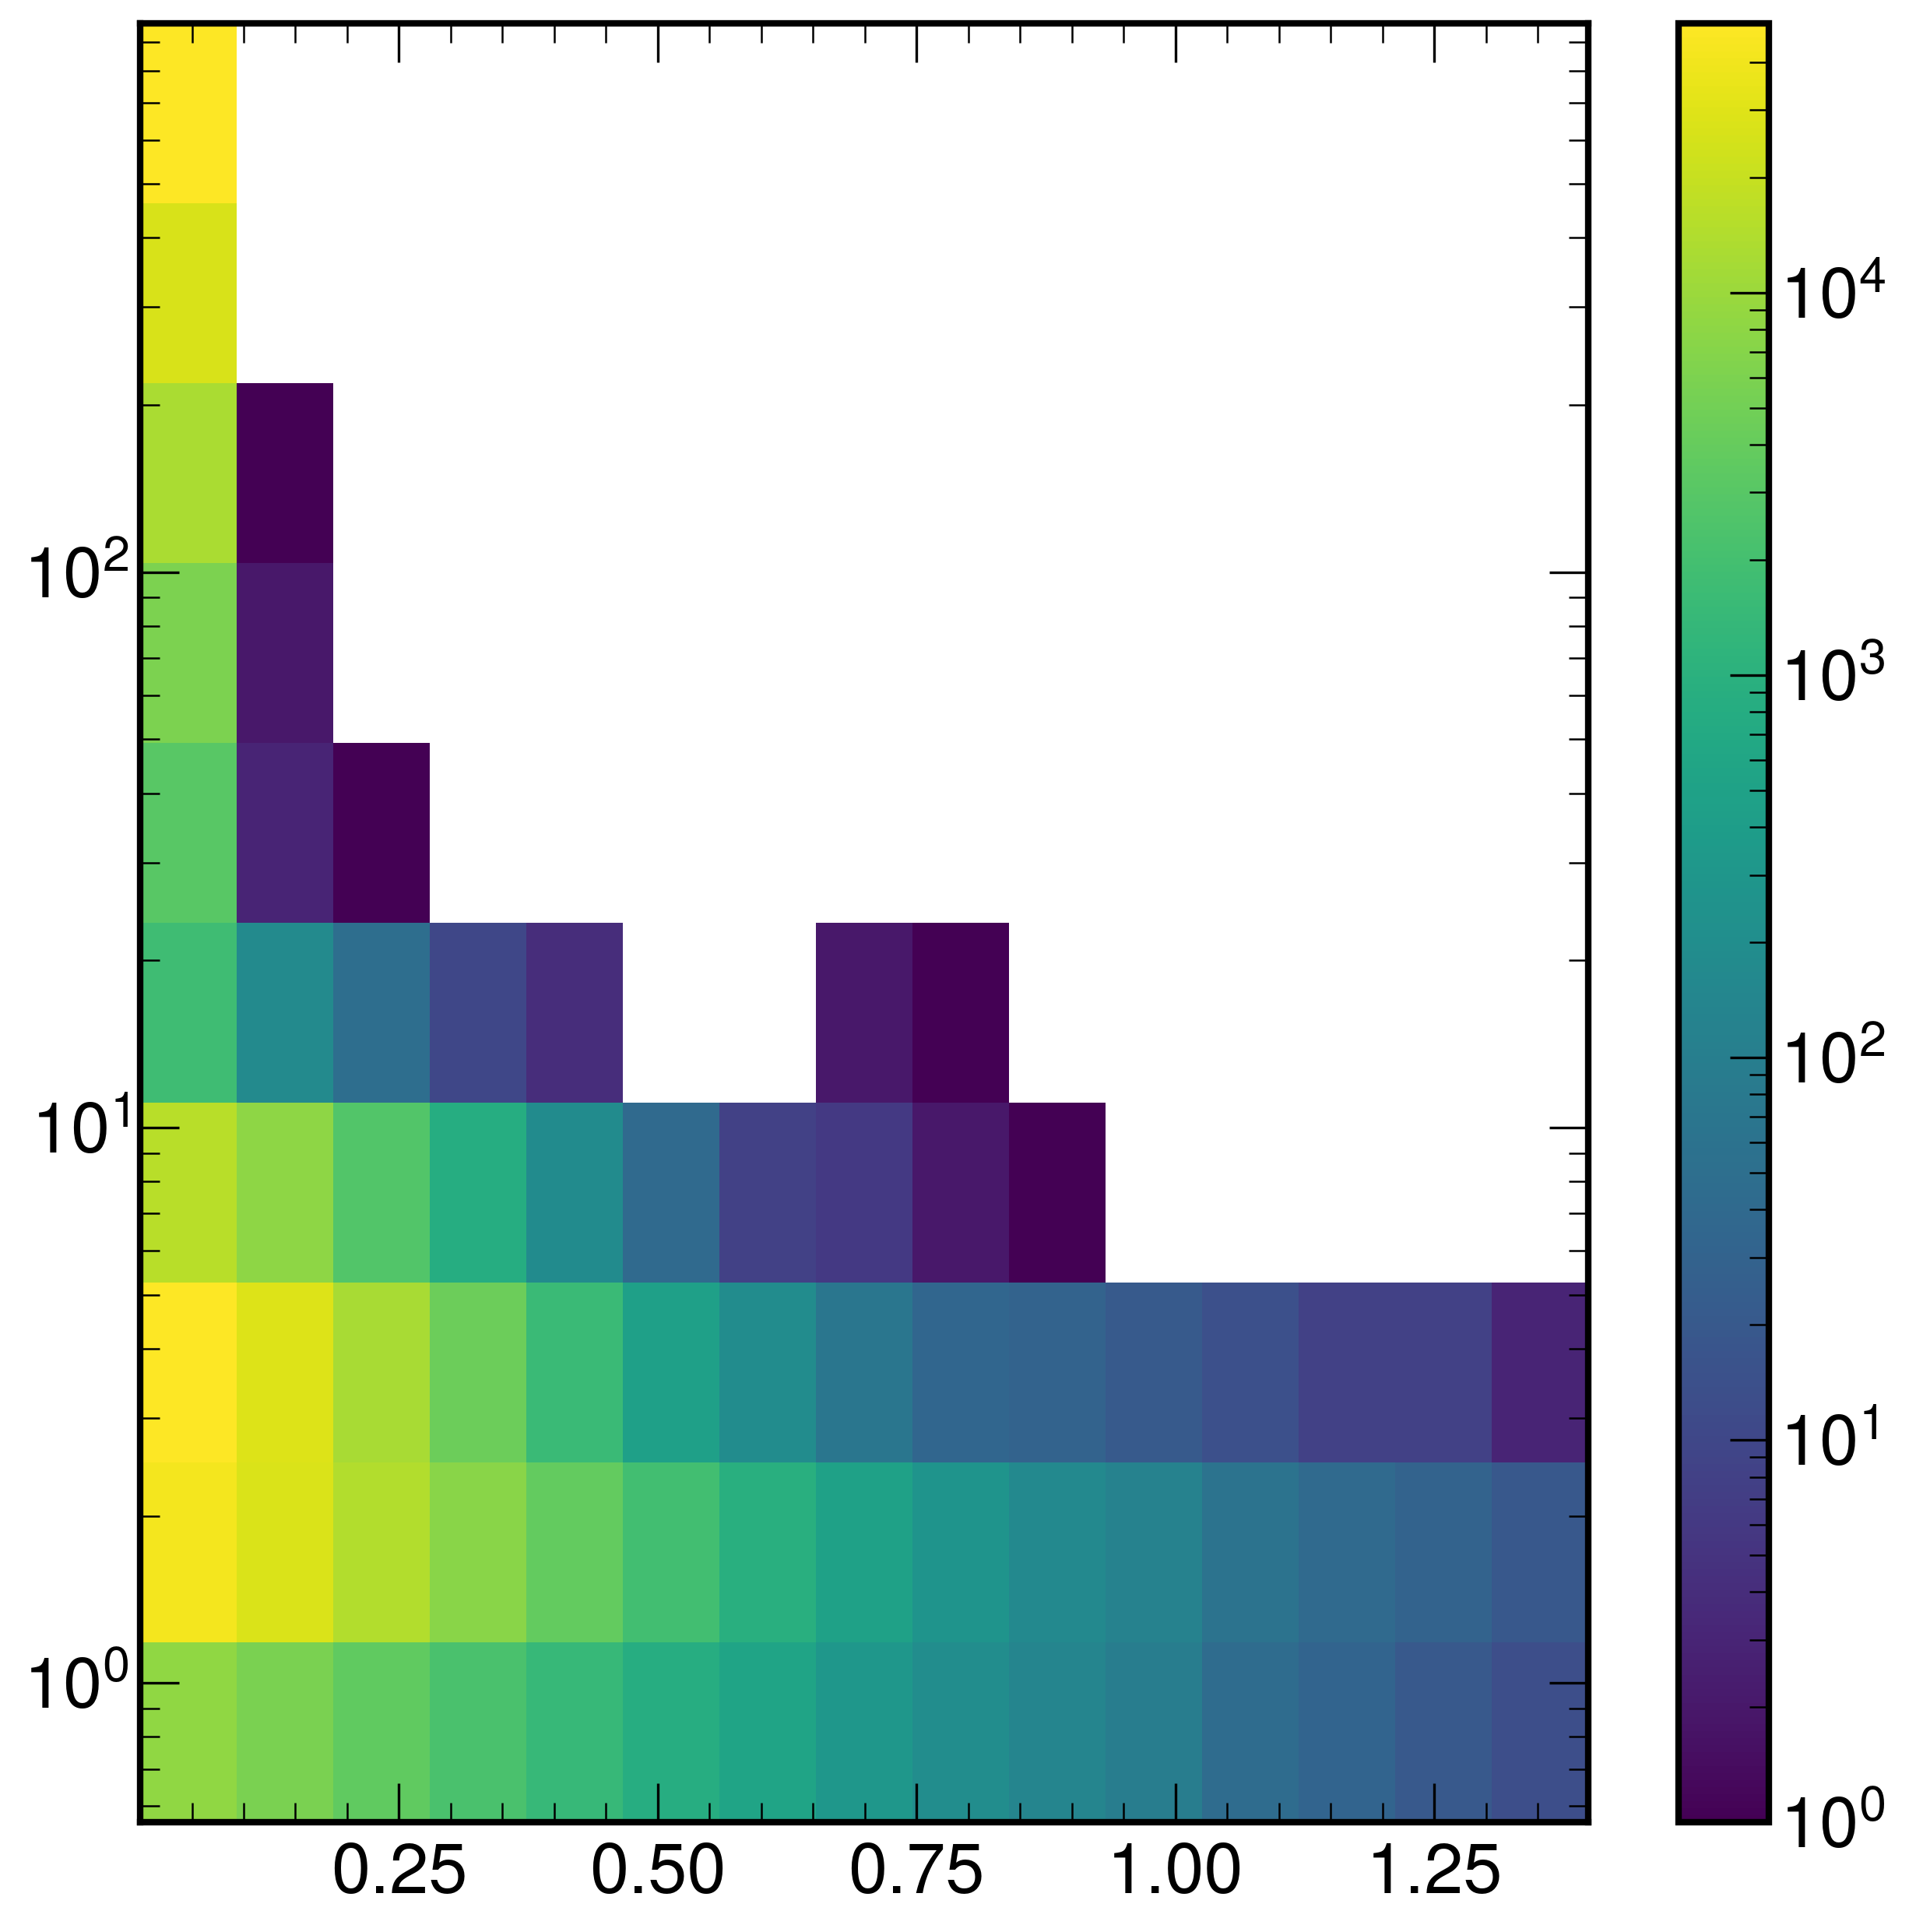

In [60]:
import matplotlib.colors as mcolors
e_nbins = 10
max_e = np.max(trackster_energy)
min_e = np.min(trackster_energy)
e_bins = np.logspace(np.log10(min_e), np.log10(max_e), e_nbins + 1)

th_nbins = 15
max_th = np.max(del_theta_flat)
min_th =np.min(del_theta_flat)
th_bins = np.linspace(min_th, max_th, th_nbins + 1)

fig, ax = plt.subplots()
h = ax.hist2d(np.array(del_theta_flat), np.array(ak.flatten(trackster_energy)), [th_bins, e_bins], norm=mcolors.LogNorm())
fig.colorbar(h[3], ax=ax)
ax.set_yscale('log')

(array([[1.0000e+00, 4.7000e+01, 2.4800e+02, 7.1500e+02, 1.8000e+03,
         4.5950e+03, 1.1374e+04, 2.7517e+04, 5.4787e+04, 1.5657e+05],
        [0.0000e+00, 3.7000e+01, 1.5500e+02, 4.7600e+02, 1.0180e+03,
         2.3370e+03, 5.1740e+03, 1.1338e+04, 2.1115e+04, 1.9579e+04],
        [0.0000e+00, 3.0000e+01, 1.1200e+02, 2.6900e+02, 5.4400e+02,
         1.0200e+03, 1.9870e+03, 3.6830e+03, 5.9450e+03, 5.3160e+03],
        [1.0000e+00, 2.1000e+01, 7.3000e+01, 1.5900e+02, 2.7100e+02,
         4.4400e+02, 7.4200e+02, 1.1570e+03, 1.4770e+03, 1.7160e+03],
        [0.0000e+00, 1.2000e+01, 6.5000e+01, 1.0700e+02, 1.4000e+02,
         1.9200e+02, 2.6800e+02, 3.4400e+02, 4.7000e+02, 6.1600e+02],
        [1.0000e+00, 1.4000e+01, 4.1000e+01, 5.1000e+01, 6.9000e+01,
         8.0000e+01, 9.4000e+01, 1.0600e+02, 1.1200e+02, 2.7500e+02],
        [1.0000e+00, 2.1000e+01, 4.0000e+01, 3.3000e+01, 5.2000e+01,
         6.0000e+01, 3.3000e+01, 3.4000e+01, 3.3000e+01, 1.4800e+02],
        [1.0000e+00, 1.4000

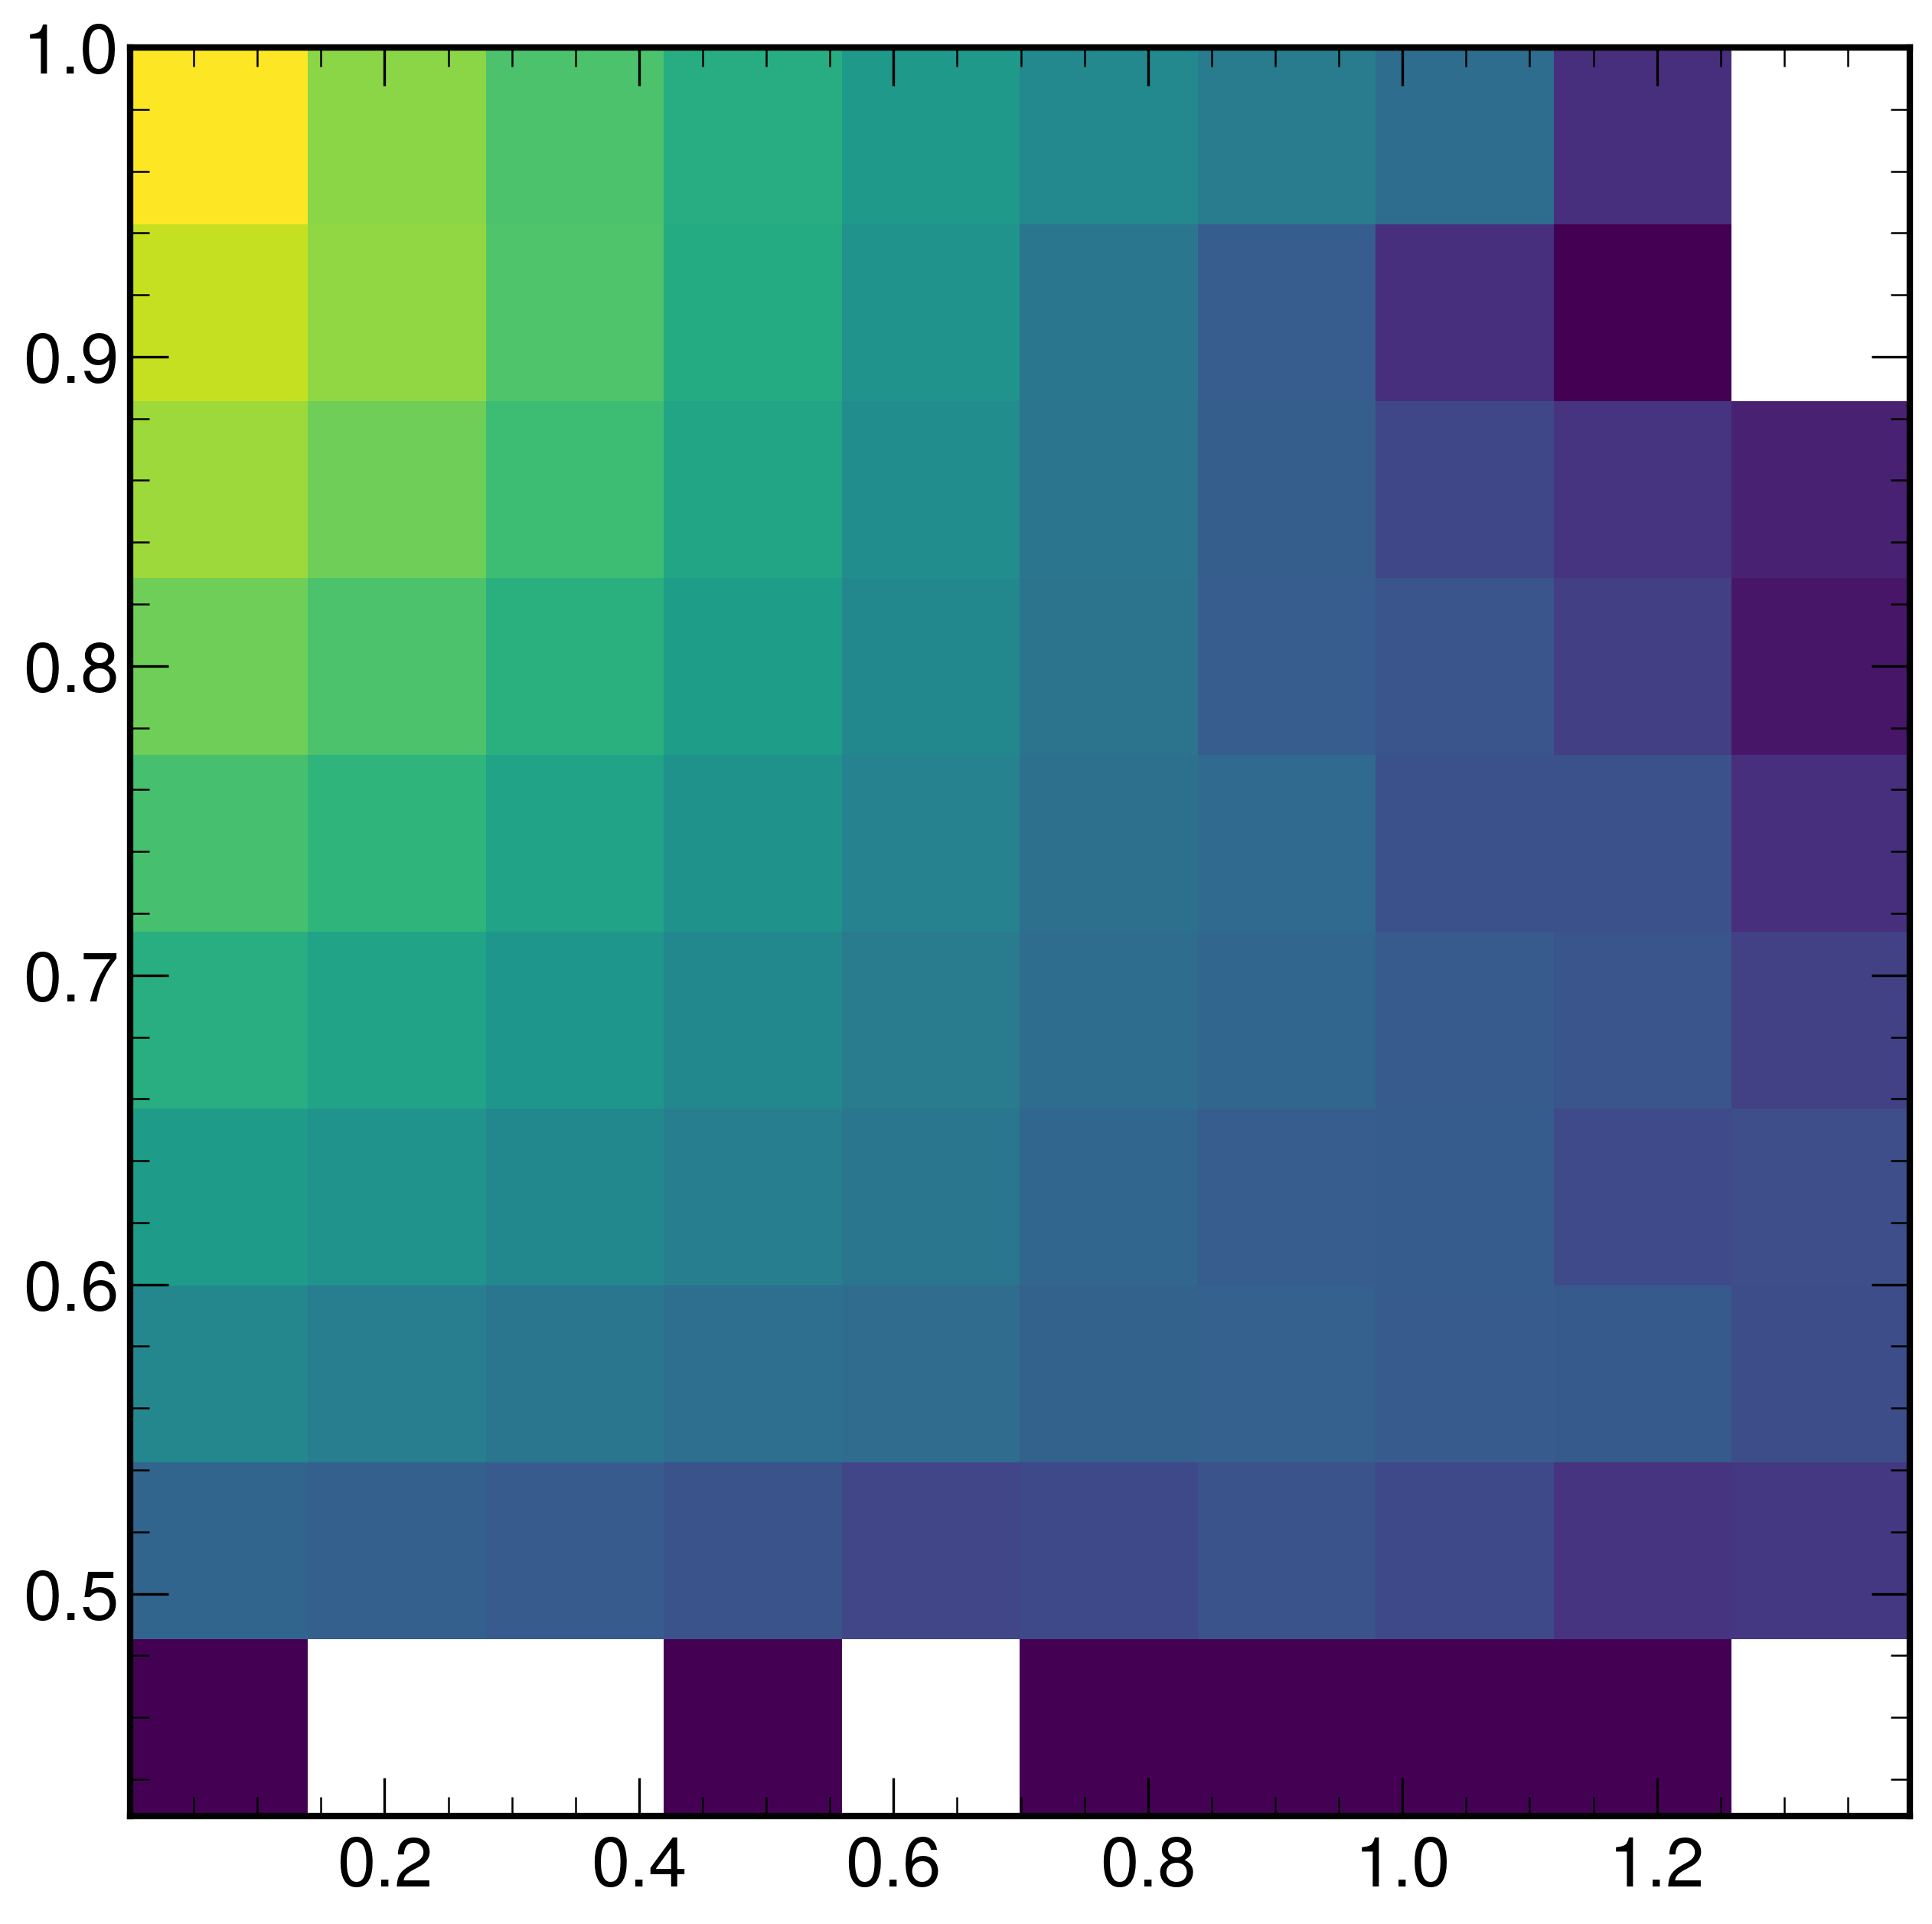

In [69]:
fig, ax = plt.subplots()
ax.hist2d(np.array(del_theta_flat), np.array(ev_1_ratio), 10, norm=mcolors.LogNorm())